# 2C - Logistic Regression Classifier

#### Prop 64 - Allows marijuana growth near schools and parks. 

The second point in the problem statement is concerned with the exposure of marijuana to minors, schoolchildren, and teenagers with the passing of Prop 64.

I am going to use the 4156 marijuana related arrests from 2015 to 2019 and use a logistic classification model to examine which features are most important in classifying whether each marijuana arrest is related to selling marijuana (target 1) or not selling marijuana (target 0). I am going to argue that one class, selling marijuana, deals with exposing children to marijuana more than the other.

With the logistic regression, the model will provide the log-odds of each independent predictor variable that explains the likelihood of whether an arrest is more likely to be related to selling marijuana.

I want to explicitly state that the model’s purpose is not for future predictions whether an individual with marijuana is more likely to be arrested for one offense over the other, but rather the objective is to examine if certain locations are more prone to marijuana exposure through selling vs. not selling marijuana. Furthermore, if there are low log-odds for `school_0.5_mile` or `school_1_mile`, then it can be argued that the arrests near schools have a low likelihood of being related to selling marijuana, which means there is no increased exposure to minors.

#### Arrests Data Dictionary:

| Column Name | Type | Description |
| --- | --- | --- | 
| Report ID | int64 | ID for the Arrest | 
| Arrest Date |  DateTime | YYYY/MM/DD |
| Time | float64 | 24 hour military time |
| Area ID |  int64 | 21 LAPD stations referred to as Geographic Areas that are sequentially numbered from 1-21 |
| Area Name | object  | Area ID's name designation that references a landmark or the surrounding community that an LAPD station is responsible for|
| Reporting District | int64 |  A four-digit code that represents a sub-area within a Geographic Area | 
| Age | int64 | Age of the arrestee | 
| Sex Code | object| F - Female, M - Male |
| Descent Code | object | Arrestee's descent code |
| Charge Group Code | object | Category of arrest charge |
| Charge Group Description | object | Defines the charge provided | 
| Arrest Type Code | object | A code to indicate the type of charge the individual was arrested for. D - Dependent F - Felony I - Infraction M - Misdemeanor O - Other |
| Charge | object | The charge the individual was arrested for |
| Charge  Description | object | Defines the Charge provided |
| Address | object | Street address of crime incident |
| Location | object  | The location where the crime incident occurred. XY coordinates reflect the nearest 100 block |
| disp_0.5_mile | int64 | Number of dispensaries within 0.5 miles of each arrest | 
| disp_1_mile | int64 | Number of dispensaries within 1 mile of each arrest | 
| school_0.5_mile | int64 | Number of school(s) within 0.5 miles of each arrest | 
| school_0.5_mile | int64 | Number of school(s) within 1 mile of each arrest | 

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

DO = '#7D1B7E'

%matplotlib inline

plt.style.use('fivethirtyeight')

In [203]:
arrests = pd.read_csv('../data/all_marijuana_arrests.csv')
arrests.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,lat,long,disp_0.5_mile,disp_1_mile,school_0.5_mile,school_1_mile
0,2015-01-01,1610.0,Southeast,19,M,B,M,possess 28.5 grams or less of marijuana**,33.9456,-118.2739,1,2,5,16
1,2015-01-01,820.0,Hollywood,23,M,B,F,transport/sell/furnish/etc marijuana,34.1016,-118.3387,0,5,2,4
2,2015-01-02,1030.0,Pacific,24,F,W,F,transport/sell/furnish/etc marijuana,33.9920,-118.4201,1,2,5,9
3,2015-01-02,1530.0,Pacific,30,M,O,F,possession marijuana for sale,33.9440,-118.4073,0,1,0,0
4,2015-01-03,1940.0,Southwest,26,M,H,F,transport/sell/furnish/etc marijuana,34.0260,-118.3652,0,1,2,5


### Creating Classes

I am going to create 2 different classes, `sell` and `not sell`. Selling marijuana exposes marijuana to children more, and the `not sell` class deals with marijuana arrests that affect the arrestee, such as the possession of marijuana. The charges based in the `Charge Description` will be grouped accordingly.

In [227]:
charge_description_list = list(arrests['Charge Description'].unique())

In [228]:
charge_description_list.sort()
charge_description_list

['attempt - sell/furnish/etc marijuana',
 'cultivate >6 marij plants viol envrnt law',
 'cultivating <6 marijuana plants',
 'furnishing marijuana to minor over 14 yrs',
 'give/transport/etc < 28.5 grams marijuana',
 'induce/etc minor to use/sell marijuana',
 'minor poss 28.5+ grams marijuana/school',
 'minor poss < 28.5 grams marijuana/school',
 'poss for sale of marijuana to a minor',
 'poss marijuana or concentrated cannabis',
 'poss of more than 28.5 grams of marijuana',
 'poss open cont/packg marij drivr/passnger',
 'poss/sale marij ovr 21 employ per 20/belw',
 'poss/smoke/ingest marij school/daycare/yc',
 'possess 28.5 grams or less of marijuana',
 'possess 28.5 grams or less of marijuana**',
 'possess marijuana for sale',
 'possess marijuana for sale under age 18',
 'possess of marijuana while driving veh',
 'possession marijuana for sale',
 'possession of marijuana in school',
 'sale/offer to sell/transport marijuana',
 'sale/trans >28.5g marijuana or >4g',
 'sale/transport mari

In [226]:
z = arrests['Charge Description'].map(lambda x: 'sell' if 'sale' in x else x)
z = z.map(lambda x: 'sell' if 'sell' in x else x)
z = z.map(lambda x: 'not sell' if 'sell' not in x else x)
z.value_counts(normalize = True)

sell        0.632579
not sell    0.367421
Name: Charge Description, dtype: float64

Since the classes are a bit unbalanced, I am going to stratify them so there is the same proportion of `sell` and `not sell` observations in both the train and test datasets.

In [229]:
arrests['target'] = z 

In [231]:
arrests['target'] = arrests['target'].map(lambda x: 1 if x == 'sell' else 0)

Creating the predictor variables `X`:

Since `disp_1_mile` includes values in `disp_0.5_mile` and `school_1_mile` includes values in `school_0.5_mile`, I will drop both `disp_0.5_mile` and `school_0.5_mile` due to the heavy correlation.

In [235]:
arrests[['disp_0.5_mile','disp_1_mile']].corr()

,disp_0.5_mile,disp_1_mile
disp_0.5_mile,1.000000,0.821403
disp_1_mile,0.821403,1.000000


In [236]:
arrests[['school_0.5_mile','school_1_mile']].corr()

,school_0.5_mile,school_1_mile
school_0.5_mile,1.000000,0.771906
school_1_mile,0.771906,1.000000


In [234]:
arrests.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,lat,long,disp_0.5_mile,disp_1_mile,school_0.5_mile,school_1_mile,target
0,2015-01-01,1610.0,Southeast,19,M,B,M,possess 28.5 grams or less of marijuana**,33.9456,-118.2739,1,2,5,16,0
1,2015-01-01,820.0,Hollywood,23,M,B,F,transport/sell/furnish/etc marijuana,34.1016,-118.3387,0,5,2,4,1
2,2015-01-02,1030.0,Pacific,24,F,W,F,transport/sell/furnish/etc marijuana,33.9920,-118.4201,1,2,5,9,1
3,2015-01-02,1530.0,Pacific,30,M,O,F,possession marijuana for sale,33.9440,-118.4073,0,1,0,0,1
4,2015-01-03,1940.0,Southwest,26,M,H,F,transport/sell/furnish/etc marijuana,34.0260,-118.3652,0,1,2,5,1


### Fitting Logistic Regression Classifier

In [271]:
X = arrests.drop(['Arrest Date','Charge Description','target','disp_0.5_mile','school_0.5_mile'],1)

# creating dummy variables for sex, descent, and arrest type code
X = pd.get_dummies(X)
y = arrests['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [272]:
# Fitting the logistic regression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [273]:
# train score
train_accuracy = lr.score(X_train, y_train)
print(f'Train Accuracy: {round(train_accuracy,2)}')

# test score
test_accuracy = lr.score(X_test, y_test)
print(f'Test Accuracy: {round(test_accuracy,2)}')

Train Accuracy: 0.88
Test Accuracy: 0.91


The logistic regression classifier model has a train accuracy score of 88% and a test accuracy score of 91% which means it is able to correctly identify whether an arrest is related to selling marijuana or not selling marijuana at a high percentage.

### Features and Log-Odds

I will now examine the top features that determine whether an arrest is more likely to be linked to selling marijuana which increases marijuana exposure to minors.

In [274]:
beta = lr.coef_[0]
features = list(X.columns)

beta_df = pd.DataFrame({'features': features, 'beta' :beta})
beta_df.set_index('features',inplace = True)

beta_df['log_odds'] = beta_df['beta'].map(lambda x: np.exp(x))

beta_df = beta_df.sort_values('log_odds',ascending=False)
beta_df.head(10)
# top 9 out of 10 features that likely predict that a marijuana crime deals with POSESSIONS are areas:

,beta,log_odds
features,,
Arrest Type Code_F,3.767773,43.283555
Area Name_Southeast,1.248010,3.483404
Area Name_Hollywood,0.971852,2.642835
Area Name_Pacific,0.861264,2.366150
Area Name_West LA,0.599460,1.821134
Area Name_Harbor,0.565094,1.759612
Area Name_Olympic,0.561806,1.753836
Descent Code_B,0.550516,1.734147
Area Name_Northeast,0.344405,1.411150


The top feature `Arrest Type Code_F`, indicates that if the arrestee was charged a felony, then the arrestee is 43 times as likely to be arrested for selling marijuana. The top 8 out of 10 log-odds features are based on the Area Name which are based on the LAPD sections. For example, a person is 3.5 times as likely to be arrested for selling marijuana in Southeast Los Angeles than not selling marijuana, and so forth.

In [261]:
beta_df[beta_df.index == 'school_1_mile']

,beta,log_odds
features,,
school_1_mile,0.032505,1.033039


The feature that indicates how many schools are within a half mile from the arrest only has a log odd of 1, which means arrests near schools have the same likelihood of either selling marijuana and not selling marijuana. This indicates that there is less of a likelihood of marijuana exposure to minors.

### Logistic Regression - Proba

In the following plot, I will look at the the probas for each arrest observation, which indicates the probability of whether an arrest observation leans towards selling marijuana or not selling marijuana. The plots will expose the overlap between the arrest observation likelihoods. 

In [288]:
# Code adapted from Brian Kane
pred_probas_selling = lr.predict_proba(X_test)[:,1]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_probas_selling})

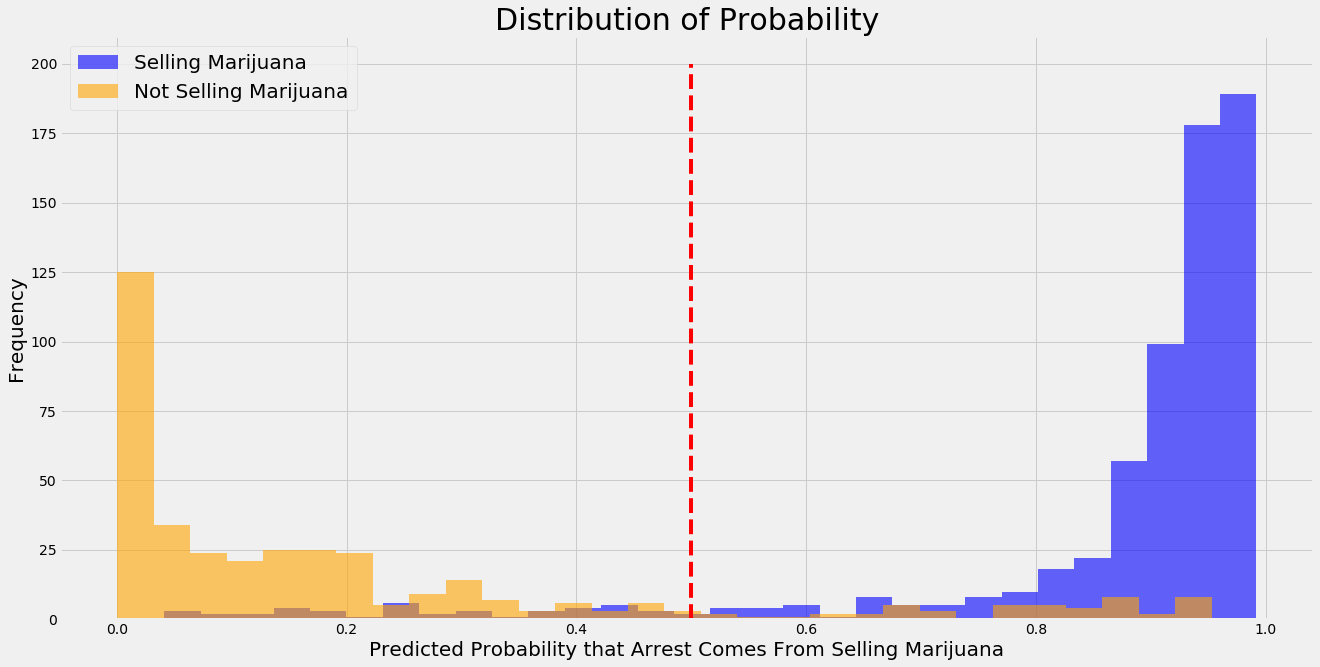

In [292]:
# Code adapted from Brian Kane
plt.figure(figsize = (20,10))

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=30,
         color='b',
         alpha = 0.6,
         label='Selling Marijuana')

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=30,
         color='orange',
         alpha = 0.6,
         label='Not Selling Marijuana')

plt.vlines(x=0.5,
           ymin = 0,
           ymax = 200,
           color='r',
           linestyle = '--')

plt.title('Distribution of Probability', fontsize=30)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Predicted Probability that Arrest Comes From Selling Marijuana', fontsize=20)

plt.legend(fontsize=20);

The distribution of probability indicate high-certainty predictions for both classes and there is minimal overlap between the two classes.

### Plotting the Area Names and Arrests

In the following scatterplots, I will attempt to visualize the top 8 features which are LAPD sections.

In [302]:
beta_df = beta_df[beta_df.index.str.contains('Area Name')].head(8)

I am going to gather the coordinates for the aforementioned features by taking the [addresses](http://www.lapdonline.org/our_communities/content_basic_view/6279) from LAPD's website and converting them into coordinates.

In [304]:
#http://www.lapdonline.org/our_communities/content_basic_view/6279 

beta_df['lat'] = [33.9383761,
                  34.097986,
                  33.9920067,
                  34.0443028,
                  33.7584097,
                  34.050264,
                  34.1195162,
                  34.1842023]

beta_df['long'] = [-118.2749244,
                   -118.331013,
                   -118.4199295,
                   -118.4509833,
                   -118.2880336,
                   -118.291531,
                   -118.2497385,
                   -118.3021552]

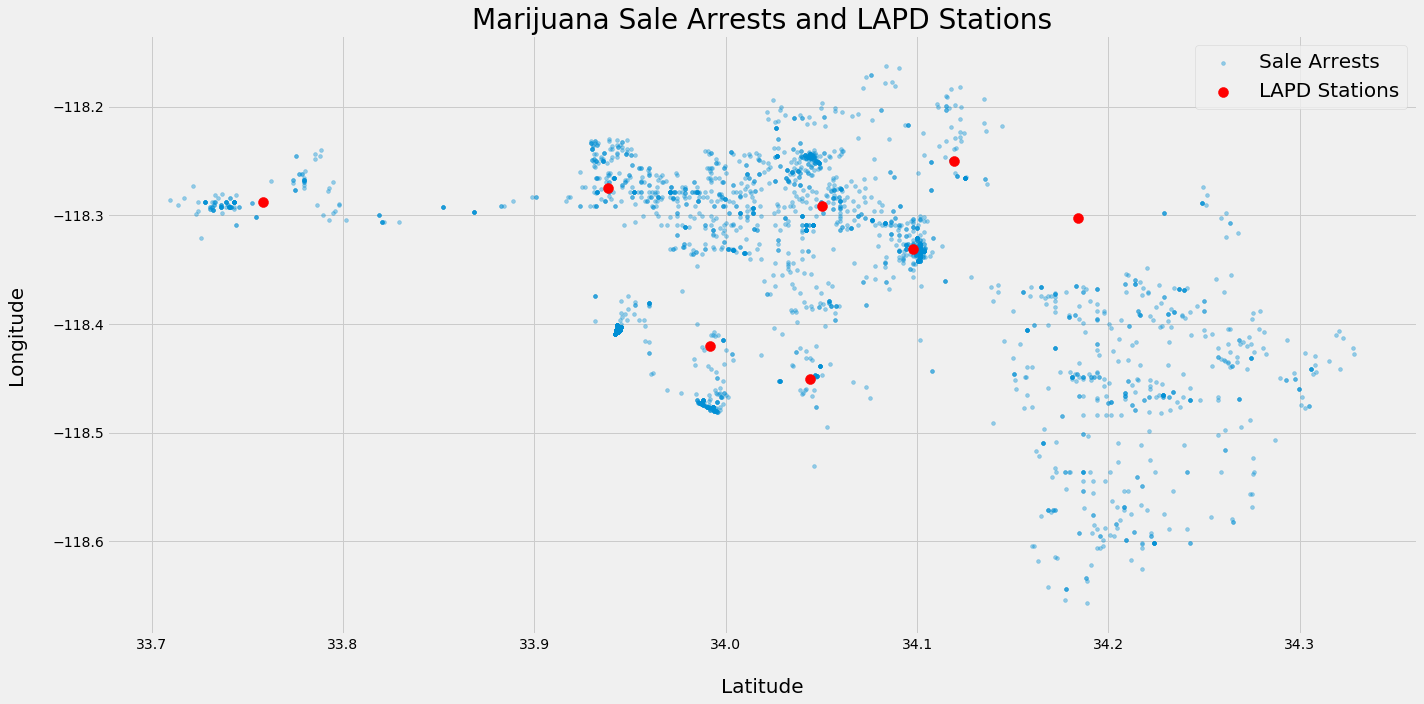

In [309]:
# Plotting top log features vs marijuana arrests, color based on their classes

fig, ax = plt.subplots(figsize =(20,10))
plt.scatter(arrests[arrests['target'] ==1]['lat'], 
            arrests[arrests['target'] ==1]['long'], 
            s = 15, 
            alpha = 0.4,
            label='Sale Arrests')

ax.scatter(beta_df['lat'], beta_df['long'], color='red', label='LAPD Stations', s = 100)
plt.title('Marijuana Sale Arrests and LAPD Stations', fontsize=28)
plt.xlabel('\nLatitude', fontsize=20)
plt.ylabel('Longitude\n', fontsize=20)
ax.legend(fontsize=20);

plt.tight_layout()
plt.savefig('../plots/classification_1.png');

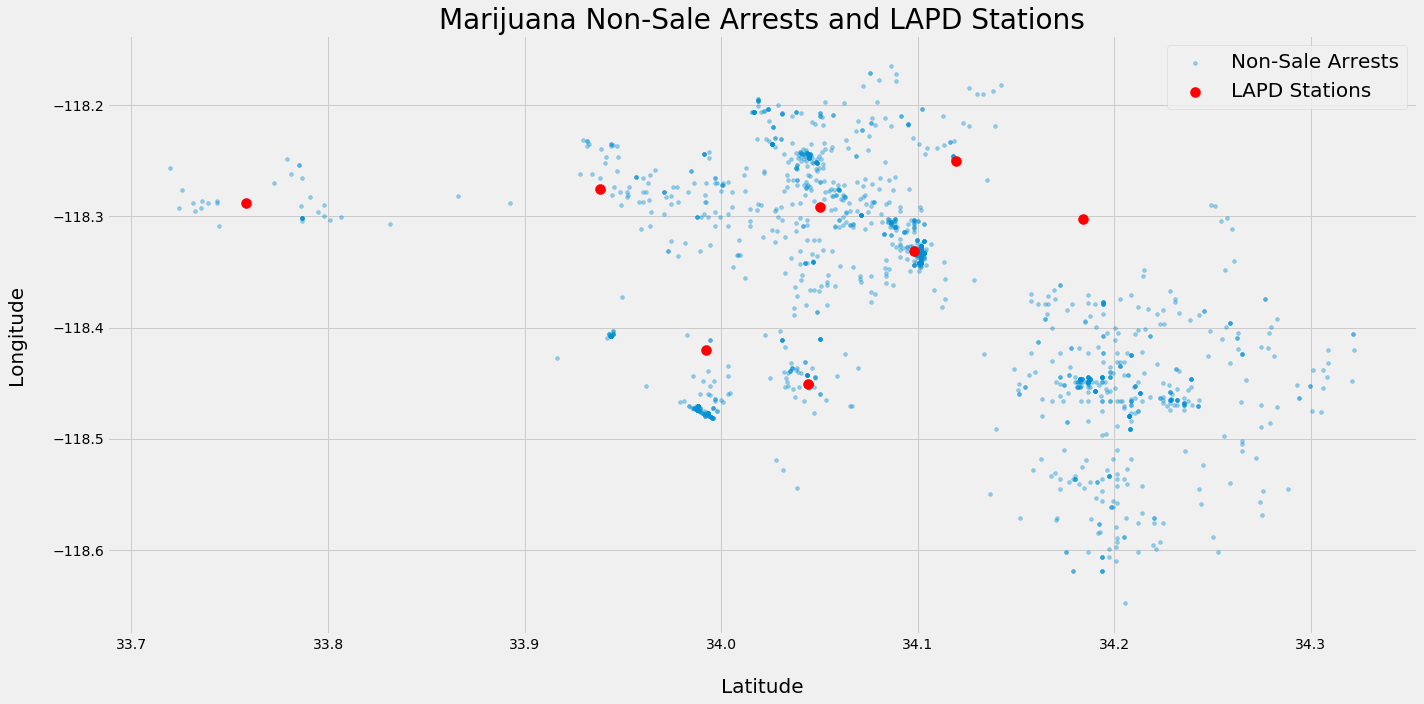

In [311]:
# Plotting top log features vs marijuana arrests, color based on their classes

fig, ax = plt.subplots(figsize =(20,10))
plt.scatter(arrests[arrests['target'] ==0]['lat'], 
            arrests[arrests['target'] ==0]['long'], 
            s = 15, 
            alpha = 0.4,
            label='Non-Sale Arrests')

ax.scatter(beta_df['lat'], beta_df['long'], color='red', label='LAPD Stations', s = 100)
plt.title('Marijuana Non-Sale Arrests and LAPD Stations', fontsize=28)
plt.xlabel('\nLatitude', fontsize=20)
plt.ylabel('Longitude\n', fontsize=20)
ax.legend(fontsize=20);

plt.tight_layout()
plt.savefig('../plots/classification_0.png');

It appears the sale arrests are more densely clustered around the LAPD Area Stations that are marked as red, but that needs to be taken with a grain of salt because the classes are imbalanced.

### Conclusion:

As a result, the fear of marijuana exposure to children and minors appears to be a non factor. There are two classes, selling marijuana and not selling marijuana, and the argument is made that selling marijuana exposes children to marijuana more. The variable `school_1_mile` is the count of schools that are within 1 mile of each arrest. Due to the log odds of `school_1_mile` equal to one, having a school within 1 mile of an arrest is as likely as the marijuana arrest to be related to selling and to not selling.